In [ ]:
!apt-cache policy libcudnn8
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH 
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

In [ ]:
!pip install tensorflow_text
!pip install tf-models-official

In [1]:
import pandas as pd 
import tensorflow as tf
import tensorflow_text as texts
import tensorflow_hub as hub
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
from tqdm import tqdm 
from official.nlp import optimization 
import seaborn as sns
import os 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data cleaning
!pip install emoji
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
import emoji
import re
import string
from tensorflow.python.compiler import xla
from seaborn.colors import xkcd_rgb
stopwords = set(STOPWORDS)
stopwords.update(["nan"])
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer 
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def text_clean(x):

    ### Light
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode()  # remove unicode characters
    x = ''.join(c for c in x if len(emoji.distinct_emoji_list(c))==0)
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x) # remove links
    # cleaning up text
    x = re.sub(r'\'\w+', '', x) 
    x =re.sub(r"([0-9])", r" ",x)  
    x = re.sub(r'\s{2,}', ' ', x)
    x=re.sub(' +', ' ', x).strip(' ') 
    
    ### Heavy
    x = re.sub("@[A-Za-z0-9]+","",x)
    x = x.replace("#", "").replace("_", " ")
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    x = x.split() 
    x =  [word for word in x if (word not in stopwords) and len(word) > 3]
    x=" ".join(x)
    x = [stemmer.stem(word) for word in x.split(' ')]
    x=" ".join(x)
    x = [lemmatizer.lemmatize(word) for word in x.split(' ')]
    x=" ".join(x)
    return x

In [ ]:
tweets = ["Get ready for #NatGeoEarthDay! Join us on 4/21 for an evening of music and celebration, exploration and inspiration https://on.natgeo.com/3t0wzQy.",
"Coral in the shallows of Aitutaki Lagoon, Cook Islands, Polynesia https://on.natgeo.com/3gkgq4Z",
"Don't miss our @reddit AMA with author and climber Mark Synnott who will be answering your questions about his historic journey to the North Face of Everest TODAY at 12:00pm ET! Start submitting your questions here: https://on.natgeo.com/3ddSkHk @DuttonBooks"]

results = [text_clean(tw) for tw in tweets]
results

In [11]:
#final dataset
df = pd.read_csv("final2.csv")
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
58716,1,Drasko they didn't cook half a bird you idiot ...
58717,1,Hopefully someone cooks Drasko in the next ep ...
58718,1,#MKR Lost the plot - where's the big Texan wi...
58719,1,RT @Benfrancisallen: It hasn't been a good few...


In [12]:
from sklearn.model_selection import train_test_split
x=df['tweet']
y=df['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state=42)


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, shuffle = True, random_state=42)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test)) 
print(len(x_val), len(y_val))

44040 44040
11745 11745
14681 14681


In [13]:
x_train,x_test,x_val = x_train.apply(text_clean),x_test.apply(text_clean),x_val.apply(text_clean)

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))

In [15]:
train_ds = train_ds.shuffle(len(x_train)).batch(32, drop_remainder=False)
val_ds = val_ds.shuffle(len(x_val)).batch(32, drop_remainder=False)
test_ds = test_ds.shuffle(len(x_test)).batch(32, drop_remainder=False)


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam
from keras_preprocessing.sequence import pad_sequences

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 40
steps_per_epoch = tf.data.experimental.cardinality(test_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
max_words = 5000
max_len = 15 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

sequences_xtest = tokenizer.texts_to_sequences(x_test)
sequences_matrix_xtest = pad_sequences(sequences_xtest,maxlen=max_len)

In [ ]:
x_test.take(-1)

AssertionError: ignored

In [21]:
model_save_name = 'overfitt.pt'
path = "/content/drive/MyDrive/Diss/GRUNN_epoch40_rl_drop2.h"
gnn_classifier_model = tf.keras.models.load_model(path,custom_objects={'AdamWeightDecay': optimizer})

In [119]:
imig["uk_gru_real"]  = predictions_grunn 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
from sklearn.metrics import confusion_matrix,classification_report

grunn = gnn_classifier_model
sequences_xtest = tokenizer.texts_to_sequences(imig["cleaned_text"])
sequences_matrix_xtest = pad_sequences(sequences_xtest,maxlen=max_len)

predictions_grunn = grunn.predict(sequences_matrix_xtest)
def predict_tweet_sentiment(score):
    return 1 if score>0.5 else 0
model_predictions = [predict_tweet_sentiment(score) for score in predictions_grunn]

print(classification_report(model_predictions,imig["sentiment"]))

26/26 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.75      0.63      0.69       556
           1       0.39      0.52      0.45       248

    accuracy                           0.60       804
   macro avg       0.57      0.58      0.57       804
weighted avg       0.64      0.60      0.61       804



In [293]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(afghan["sentiment"],model_predictions)
cf_matrix

array([[116,  45],
       [107,  98]])

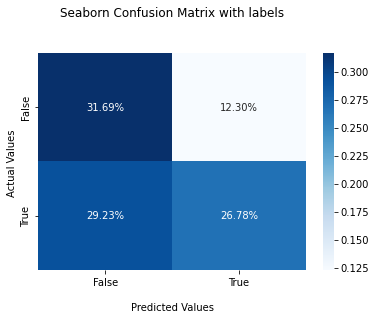

In [294]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

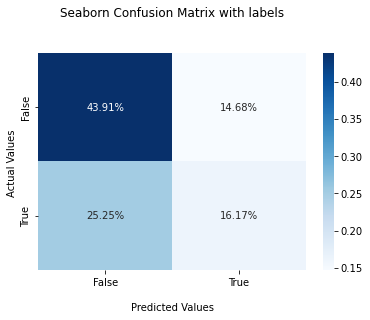

In [291]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
afghan[["renderedContent","clean_tweet","vadar compound","sentiment","gr_pred"]][afghan.sentiment==afghan.gr_pred]

In [66]:
afghan["gr_pred"] = model_predictions
could_afghan_grnn = afghan[["renderedContent","clean_tweet","vadar compound","sentiment","gr_pred"]][afghan.gr_pred==1] 
could_afghan_grnn["clean_tweet_3"] = could_afghan_grnn["clean_tweet"].apply(text_clean)

In [ ]:
imig["gr_pred"] = model_predictions
imig_cloud_gr=imig[["text","cleaned_text","vadar compound","sentiment","gr_pred"]][imig.gr_pred ==1] 
imig_cloud_gr["cleaned_text_3"] = imig_cloud_gr["cleaned_text"].apply(text_clean)

In [ ]:
afghan["gr_pred"] = model_predictions
afghan[["renderedContent","clean_tweet","vadar compound","sentiment","gr_pred"]][afghan.sentiment==afghan.gr_pred]

In [ ]:
imig["bert_pred"] = y_pred
imig[["text","cleaned_text","vadar compound","sentiment","bert_pred"]][imig.sentiment ==1][imig.sentiment!=imig.bert_pred]

In [107]:
def make_wordcloud(correct):
    comment_words=""
    for val in correct: 
        val = str(val).lower()

      
        comment_words += val
    print(comment_words[0:100])
    def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
        h = 344
        s = int(100.0 * 255.0 / 255.0)
        l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
        return "hsl({}, {}%, {}%)".format(h, s, l)

    wordcloud = WordCloud(
                            background_color='white',
                            stopwords=stopwords,
                            max_words=100,
                            max_font_size=60, 
                            random_state=42).generate(comment_words)
  
    plt.figure(1)
    plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
    plt.axis("off")
    #plt.tight_layout(pad = 0)

    plt.show()

everything going ukraine wanted say rarely use phrase remember russian citizens russian immigrants s


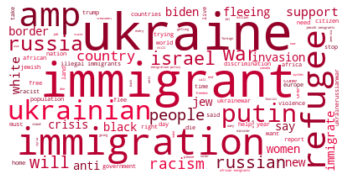

In [115]:
make_wordcloud(imig_cloud_gr.cleaned_text)

In [ ]:
caught = imig[["text","cleaned_text","vadar compound","sentiment","bert_pred"]][imig.bert_pred ==1] 
caught

In [ ]:
imig["bert_pred"] = y_pred
imig[["text","cleaned_text","vadar compound","sentiment","bert_pred"]][imig.sentiment ==1][imig.sentiment==imig.bert_pred]

In [ ]:
afghan["bert_pred"] = y_pred
afghan[["renderedContent","clean_tweet","vadar compound","sentiment","bert_pred"]][afghan.sentiment!=afghan.bert_pred]

In [23]:
model_save_name = 'overfitt.pt'
path = "/content/drive/MyDrive/Diss/GRUNN_epoch40_rl_drop2.h"
cnn_classifier_model = tf.keras.models.load_model(path,custom_objects={'AdamWeightDecay': optimizer})

In [20]:
cnn_classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

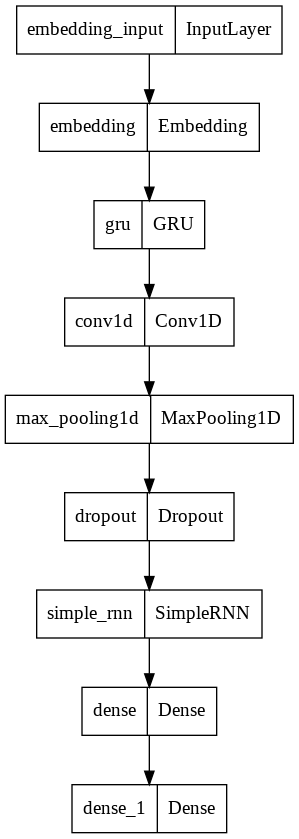

In [24]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [33]:
from itertools import chain
result =  cnn_classifier_model.predict(imig_test)
print(result)
tweet = []
test_labels = []
predictions = []
for tweet, labels in imig_test.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(tweet))


flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)
type(y_pred)
y_test = np.array(list(chain.from_iterable(test_labels)))

24/24 [==============================] - 3s 88ms/step
[[9.9845326e-01 1.5466735e-03]
 [9.9982029e-01 1.7968449e-04]
 [9.9967408e-01 3.2589131e-04]
 ...
 [3.0824915e-02 9.6917510e-01]
 [9.9988246e-01 1.1750277e-04]
 [9.9988413e-01 1.1591603e-04]]
1/1 [==============================] - 1s 779ms/step


In [34]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.88      0.78       519
           1       0.44      0.20      0.27       239

    accuracy                           0.67       758
   macro avg       0.57      0.54      0.53       758
weighted avg       0.62      0.67      0.62       758



In [ ]:
cnn_classifier_model.evaluate(imig_test)

In [343]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       471
           1       0.50      0.58      0.54       333

    accuracy                           0.59       804
   macro avg       0.58      0.59      0.58       804
weighted avg       0.60      0.59      0.59       804



In [347]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.67      0.59      0.63       471
           1       0.50      0.58      0.54       333

    accuracy                           0.59       804
   macro avg       0.58      0.59      0.58       804
weighted avg       0.60      0.59      0.59       804



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.49      0.81      0.61       121
           1       0.57      0.23      0.33       132

    accuracy                           0.51       253
   macro avg       0.53      0.52      0.47       253
weighted avg       0.54      0.51      0.47       253



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        92
           1       0.55      0.27      0.36        45

    accuracy                           0.69       137
   macro avg       0.63      0.58      0.58       137
weighted avg       0.66      0.69      0.65       137



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8391
           1       0.93      0.89      0.91      6290

    accuracy                           0.93     14681
   macro avg       0.93      0.92      0.92     14681
weighted avg       0.93      0.93      0.93     14681



In [344]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[278, 193],
       [139, 194]])

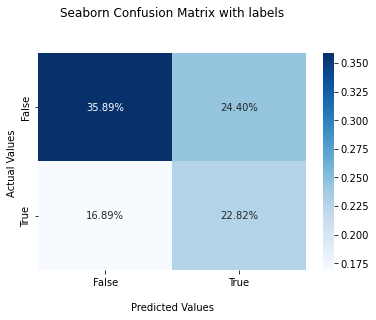

In [333]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

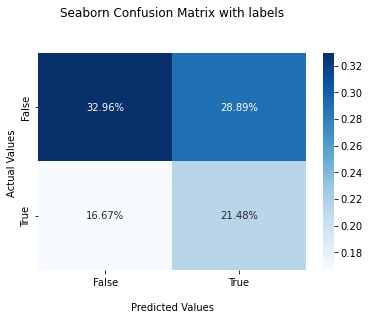

In [94]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

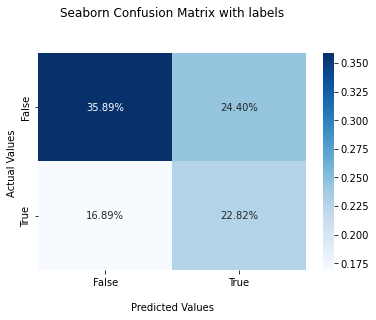

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
import pickle
filename = 'finalized_model.sav'
from sklearn.feature_extraction.text import TfidfVectorizer

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(x)
Train_X_Tfidf = Tfidf_vect.transform(x_train)
Test_X_Tfidf = Tfidf_vect.transform(imig["cleaned_text"])
y_predict = loaded_model.predict(Test_X_Tfidf)


cf_matrix=confusion_matrix(imig["sentiment"], y_predict)


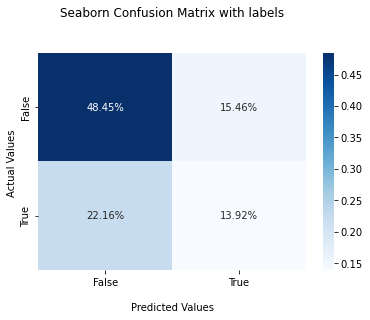

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(x)
Train_X_Tfidf = Tfidf_vect.transform(x_train)
Test_X_Tfidf = Tfidf_vect.transform(x_test)

In [32]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_i = SentimentIntensityAnalyzer()

def vadar_sentiment(text):
    """ Calculate and return the nltk vadar (lexicon method) sentiment """
    return sent_i.polarity_scores(text)['compound']

# create new column for vadar compound sentiment score
afghan['vadar compound'] = afghan['clean_tweet'].apply(vadar_sentiment)

def categorise_sentiment(sentiment, neg_threshold=-0.05, pos_threshold=0.05):
    """ categorise the sentiment value as positive (1), negative (-1) 
        or neutral (0) based on given thresholds """
    if sentiment < neg_threshold:
        label = 'negative'
    elif sentiment > pos_threshold:
        label = 'positive'
    else:
        label = 'neutral'
    return label

# new col with vadar sentiment label based on vadar compound score
afghan['vadar sentiment'] = afghan['vadar compound'].apply(categorise_sentiment)

# # plot distribution of article sentiments for each newspaper
# plt.figure(figsize=(8,8))
# sns.countplot(x='cleaned', data=afghan, hue='vadar sentiment')
# plt.title('VADAR Sentiment Analysis', weight='bold')
# plt.ylabel('Number of Articles', fontsize=10, weight='bold')
# plt.xlabel('VADAR Sentiment', fontsize=10, weight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0.0)
# plt.show() 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_i = SentimentIntensityAnalyzer()

def vadar_sentiment(text):
    """ Calculate and return the nltk vadar (lexicon method) sentiment """
    return sent_i.polarity_scores(text)['compound']

# create new column for vadar compound sentiment score
imig['vadar compound'] = imig['cleaned_text'].apply(vadar_sentiment)

def categorise_sentiment(sentiment, neg_threshold=-0.5, pos_threshold=0.05):
    """ categorise the sentiment value as positive (1), negative (-1) 
        or neutral (0) based on given thresholds """
    if sentiment < neg_threshold:
        label = 'negative'
    elif sentiment > pos_threshold:
        label = 'positive'
    else:
        label = 'neutral'
    return label

# new col with vadar sentiment label based on vadar compound score
imig['vadar sentiment'] = imig['vadar compound'].apply(categorise_sentiment)

# # plot distribution of article sentiments for each newspaper
# plt.figure(figsize=(8,8))
# sns.countplot(x='cleaned', data=afghan, hue='vadar sentiment')
# plt.title('VADAR Sentiment Analysis', weight='bold')
# plt.ylabel('Number of Articles', fontsize=10, weight='bold')
# plt.xlabel('VADAR Sentiment', fontsize=10, weight='bold')
# plt.legend(bbox_to_anchor=(1.02, 1.0), loc=2, borderaxespad=0.0)
# plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [327]:
total_pos=len(imig.loc[imig['vadar sentiment'] == "positive"])
total_neg=len(imig.loc[imig['vadar sentiment'] == "negative"])
total_neu=len(imig.loc[imig['vadar sentiment'] == "neutral"])
total_tweets=len(imig)
print("Total Positive Tweets % : {:.2f}".format( (total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 35.36
Total Negative Tweets % : 39.71
Total Neutral Tweets % : 24.92


In [15]:
total_pos=len(imig.loc[imig['vadar sentiment'] == "positive"])
total_neg=len(imig.loc[imig['vadar sentiment'] == "negative"])
total_neu=len(imig.loc[imig['vadar sentiment'] == "neutral"])
total_tweets=len(imig)
print("Total Positive Tweets % : {:.2f}".format( (total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 35.36
Total Negative Tweets % : 25.00
Total Neutral Tweets % : 39.64


In [33]:
total_pos=len(afghan.loc[afghan['vadar sentiment'] == "positive"])
total_neg=len(afghan.loc[afghan['vadar sentiment'] == "negative"])
total_neu=len(afghan.loc[afghan['vadar sentiment'] == "neutral"])
total_tweets=len(afghan)
print("Total Positive Tweets % : {:.2f}".format( (total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 28.69
Total Negative Tweets % : 56.01
Total Neutral Tweets % : 15.30


In [194]:
total_pos=len(afghan.loc[afghan['vadar sentiment'] == "positive"])
total_neg=len(afghan.loc[afghan['vadar sentiment'] == "negative"])
total_neu=len(afghan.loc[afghan['vadar sentiment'] == "neutral"])
total_tweets=len(afghan) 
print("Total Positive Tweets % : {:.2f}".format( (total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 28.69
Total Negative Tweets % : 36.34
Total Neutral Tweets % : 34.97


In [ ]:
total_pos=len(afghan.loc[afghan['vadar sentiment'] == "positive"])
total_neg=len(afghan.loc[afghan['vadar sentiment'] == "negative"])
total_neu=len(afghan.loc[afghan['vadar sentiment'] == "neutral"])
total_tweets=len(afghan) 
print("Total Positive Tweets % : {:.2f}".format( (total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))

Total Positive Tweets % : 28.69
Total Negative Tweets % : 56.01
Total Neutral Tweets % : 15.30


In [14]:
imig.drop(imig[imig["vadar sentiment"] == "neutral"].index, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
imig["sentiment"] = imig["vadar sentiment"]
imig["sentiment"].replace({"positive": 0}, inplace=True)
#imig["sentiment"].replace({"neutral": 0}, inplace=True)
imig["sentiment"].replace({"negative": 1}, inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [39]:
afghan["sentiment"] = afghan["vadar sentiment"]
afghan["sentiment"].replace({"positive": 0}, inplace=True)
#afghan["sentiment"].replace({"neutral": 0}, inplace=True)
afghan["sentiment"].replace({"negative": 1}, inplace=True)


In [ ]:
afghan["clean_tweet"]

162      bring immigrants afghanistan across southern b...
206      well boris currently spending billions afghani...
339      haven yet please see resource page website ong...
508      guy country wouldn fucked now gas wouldn cost ...
1575     afghanistan immigrants nothing entire welfare ...
                               ...                        
86566    one arizona sheriff sees many similarities imm...
86988    latest ircc figures afghanistan evacuees arriv...
87023    admitted evacuees afghanistan including citize...
87084    many american jobs will illegal immigrants afg...
87389    plan fight delta variant open borders flood mo...
Name: clean_tweet, Length: 253, dtype: object

In [88]:
imig_subset = imig.sample(n=270)

In [255]:
imig 

,text,cleaned_text,vadar compound,vadar sentiment,sentiment,bert_pred
0,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",gee now love refugees love seeing ukrainian re...,0.8807,positive,0,1
1,Putin's War on #Ukraine amplifies the need for...,putin war ukraine amplifies need scotland beco...,0.3400,positive,0,0
5,With everything that's going on #Ukraine. I wa...,everything going ukraine wanted say rarely use...,0.0772,positive,0,1
8,African immigrants in Ukraine tell Sidner they...,african immigrants ukraine tell sidner pushed ...,-0.7269,negative,1,1
12,We are offering specialist #probono advice to ...,offering specialist probono advice ukrainian n...,0.5106,positive,0,1
...,...,...,...,...,...,...
6131,Shame I'm blocked by @SuellaBraverman - How...,shame blocked people fleeing bombed war zone a...,-0.7269,negative,1,1
6132,On #bbcqt \n\n@SuellaBraverman “I am very disa...,bbcqt disappointed suggestion theres kind inhu...,0.0772,positive,0,0
6139,Suella braverman and priti patel both come fro...,suella braverman priti patel come parents asia...,-0.5423,negative,1,0
6146,#bbcqt @SuellaBraverman you have no shame. Cal...,bbcqt shame call daughter immigrant support ho...,-0.8126,negative,1,0


In [16]:
imig_test = tf.data.Dataset.from_tensor_slices((imig["cleaned_text"], imig["sentiment"]))
imig_test = imig_test.shuffle(len(imig["cleaned_text"])).batch(32, drop_remainder=False)
afghan_test = tf.data.Dataset.from_tensor_slices((afghan["clean_tweet"], afghan["sentiment"]))
afghan_test = afghan_test.shuffle(len(afghan["clean_tweet"])).batch(32, drop_remainder=False)



NameError: ignored

In [79]:
imig

,text,cleaned_text,vadar compound,vadar sentiment,sentiment
0,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",gee now love refugees love seeing ukrainian re...,0.8807,positive,0
1,Putin's War on #Ukraine amplifies the need for...,putin war ukraine amplifies need scotland beco...,0.3400,positive,0
5,With everything that's going on #Ukraine. I wa...,everything going ukraine wanted say rarely use...,0.0772,positive,0
7,#Salvini è patetico..a #mezzorainpiu ha affer...,salvini patetico mezzorainpiu affermato che mi...,0.0000,neutral,0
8,African immigrants in Ukraine tell Sidner they...,african immigrants ukraine tell sidner pushed ...,-0.7269,negative,1
...,...,...,...,...,...
6135,A smattering of timely records #FoundAtHSP tod...,smattering timely records foundathsp today ukr...,0.0000,neutral,0
6139,Suella braverman and priti patel both come fro...,suella braverman priti patel come parents asia...,-0.5423,negative,1
6146,#bbcqt @SuellaBraverman you have no shame. Cal...,bbcqt shame call daughter immigrant support ho...,-0.8126,negative,1
6152,#bbcqt Latest Tory policy to try and improve s...,bbcqt latest tory policy try improve support p...,0.0000,neutral,0


In [ ]:
df_feb = pd.read_csv("feb_sentiment_analysis_RoBERTa_raw_values.csv")

In [55]:
df_march

,text,cleaned_text
0,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",gee now love refugees love seeing ukrainian re...
1,Putin's War on #Ukraine amplifies the need for...,putin war ukraine amplifies need scotland beco...
2,Putin's War on #Ukraine amplifies the need for...,putin war ukraine amplifies need scotland beco...
3,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",gee now love refugees love seeing ukrainian re...
4,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",gee now love refugees love seeing ukrainian re...
...,...,...
6156,#German Chancellor Olaf Scholz condemned discr...,german chancellor olaf scholz condemned discri...
6157,“I am very disappointed by the suggestion that...,disappointed suggestion theres kind inhumane a...
6158,#German Chancellor Olaf Scholz condemned discr...,german chancellor olaf scholz condemned discri...
6159,“I am very disappointed by the suggestion that...,disappointed suggestion theres kind inhumane a...


In [3]:
df_march = pd.read_csv("ukr_immigration_tweets.csv") 

In [ ]:
df_feb.columns

Index(['Unnamed: 0', 'userid', 'username', 'acctdesc', 'location', 'following',
       'followers', 'totaltweets', 'usercreatedts', 'tweetid',
       'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language',
       'coordinates', 'favorite_count', 'extractedts'],
      dtype='object')

In [4]:
df_march = df_march[['text']] 
df_march["cleaned_text"] = df_march["text"].apply(text_clean)

In [5]:
imig = df_march.drop_duplicates(subset=['cleaned_text'])
imig

,text,cleaned_text
0,"Fu-Gee-La.\nOh, so NOW we all love refugees!!\...",love refuge love see ukrainian refuge embrac o...
1,Putin's War on #Ukraine amplifies the need for...,putin ukrain amplifi need scotland becom indep...
5,With everything that's going on #Ukraine. I wa...,everyth go ukrain want rare phrase rememb russ...
7,#Salvini è patetico..a #mezzorainpiu ha affer...,salvini patetico mezzorainpiu affermato miglio...
8,African immigrants in Ukraine tell Sidner they...,african immigr ukrain tell sidner push train s...
...,...,...
6135,A smattering of timely records #FoundAtHSP tod...,smatter time record foundathsp today ukrain eu...
6139,Suella braverman and priti patel both come fro...,suella braverman priti patel come parent asian...
6146,#bbcqt @SuellaBraverman you have no shame. Cal...,bbcqt shame call daughter immigr support hosti...
6152,#bbcqt Latest Tory policy to try and improve s...,bbcqt latest torus polici improv support poll ...


In [6]:
afghan = pd.read_csv("afghanistan3.csv")

In [4]:
afghan

,date,rawContent,renderedContent,id,place
0,2021-09-04 23:59:57+00:00,"@KP24 If India 🇮🇳, Australia 🇦🇺 and England 🏴󠁧...","@KP24 If India 🇮🇳, Australia 🇦🇺 and England 🏴󠁧...",1.434305e+18,NaN
1,2021-09-04 23:59:56+00:00,"Overall, do you think the U.S. role in Afghani...","Overall, do you think the U.S. role in Afghani...",1.434305e+18,NaN
2,2021-09-04 23:59:56+00:00,Afghanistan: Life for those left behind https:...,Afghanistan: Life for those left behind bbc.in...,1.434305e+18,NaN
3,2021-09-04 23:59:56+00:00,Afghanistan: Life for those left behind https:...,Afghanistan: Life for those left behind bbc.in...,1.434305e+18,NaN
4,2021-09-04 23:59:48+00:00,@Hrushik06039597 @NA2NRF It’s terror game over...,@Hrushik06039597 @NA2NRF It’s terror game over...,1.434305e+18,NaN
...,...,...,...,...,...
36554,2021-09-04 09:48:00+00:00,અફઘાનીઓ ભારતમાં આશ્રય લેવા માટે કોઈ પણ કિંમત ચ...,અફઘાનીઓ ભારતમાં આશ્રય લેવા માટે કોઈ પણ કિંમત ચ...,1.434091e+18,NaN
36555,2021-09-04 09:47:57+00:00,"Taliban is just a ""complete communication blac...","Taliban is just a ""complete communication blac...",1.434091e+18,NaN
36556,2021-09-04 09:47:57+00:00,@JKasek *Redebeitrag eines Geflüchteten zur Si...,@JKasek *Redebeitrag eines Geflüchteten zur Si...,1.434091e+18,NaN
36557,2021-09-04 09:47:54+00:00,#Corona #COVID19 #Divigate #Impfung #Impfungen...,#Corona #COVID19 #Divigate #Impfung #Impfungen...,1.434091e+18,NaN


In [7]:
afghan =afghan[afghan["renderedContent"].str.contains('immigr', regex=True, na=False)]
afghan.shape

(264, 5)

In [8]:
afghan["clean_tweet"] = afghan["renderedContent"].apply(text_clean)
afghan = afghan.drop_duplicates(subset=['clean_tweet'])


In [9]:
afghan[["renderedContent","clean_tweet"]]

,renderedContent,clean_tweet
162,@Tequila06209973 And they bring these immigran...,bring immigr afghanistan across southern borde...
206,@Brexit011 @sarahisitme @JonnieIlly @EU_NO_MOR...,well bori current spend billion afghanistan il...
339,"If you haven't yet, please see our resource pa...",haven plea resourc page websit ongo afghanista...
508,@tedcruz If the other guy was here the country...,countri wouldn fuck wouldn cost gallon regular...
1575,These Afghanistan immigrants are nothing more ...,afghanistan immigr noth entir welfar class wil...
...,...,...
86566,One #Arizona sheriff sees too many similaritie...,arizona sheriff see mani similar immigr polici...
86988,"Latest IRCC figures on Afghanistan:\n-3,000+ e...",latest ircc figur afghanistan evacue arriv can...
87023,"The US has admitted ""just over 40,000"" evacuee...",admit evacue afghanistan includ citizen law pe...
87084,How many American jobs will go to illegal immi...,mani american job will illeg immigr afghanista...


In [ ]:
taliban = pd.read_csv("taliban.csv")
taliban

In [37]:
taliban["clean_tweet"] = taliban["renderedContent"].apply(text_clean)
taliban = taliban.drop_duplicates(subset=['clean_tweet'])
taliban

,date,rawContent,renderedContent,id,place,clean_tweet
0,2021-09-21 23:59:54+00:00,@peakcapitolism and the liberals have been muc...,@peakcapitolism and the liberals have been muc...,1440465843662454790,NaN,liberals much better base building immigrant c...
1,2021-09-21 23:59:44+00:00,@cuttinchief @SS2_spacewrench @CNN America has...,@cuttinchief @SS2_spacewrench @CNN America has...,1440465801543225351,NaN,america never best brightest always people wor...
2,2021-09-21 23:59:18+00:00,Bruh Tony really called his side chick a refug...,Bruh Tony really called his side chick a refug...,1440465692688478214,NaN,bruh tony really called side chick refugee lma...
3,2021-09-21 23:58:49+00:00,"@leahmcelrath Yes, it’s our presidents @JoeBid...","@leahmcelrath Yes, it’s our presidents @JoeBid...",1440465573318590466,NaN,presidents border police teaching immigrants l...
4,2021-09-21 23:58:43+00:00,@RepFitzgerald When will Republicans take Covi...,@RepFitzgerald When will Republicans take Covi...,1440465546793742347,NaN,will republicans take covid seriously butterba...
...,...,...,...,...,...,...
4474,2021-09-21 17:00:50+00:00,A diverse coalition will continue to engage co...,A diverse coalition will continue to engage co...,1440360381524819977,NaN,diverse coalition will continue engage communi...
4476,2021-09-21 17:00:49+00:00,A diverse coalition will continue to engage co...,A diverse coalition will continue to engage co...,1440360379863891970,NaN,diverse coalition will continue engage communi...
4478,2021-09-21 17:00:49+00:00,A diverse coalition will continue to engage co...,A diverse coalition will continue to engage co...,1440360378618167304,NaN,diverse coalition will continue engage communi...
4479,2021-09-21 17:00:49+00:00,A diverse coalition will continue to engage co...,A diverse coalition will continue to engage co...,1440360377619943429,NaN,diverse coalition will continue engage communi...


In [31]:
frame=[afghan,taliban]
#frame=[df_twitter,df_labeled_data]

afghan = pd.concat(frame)
afghan

,date,rawContent,renderedContent,id,place,clean_tweet
162,2021-09-04 23:52:31+00:00,@Tequila06209973 And they bring these immigran...,@Tequila06209973 And they bring these immigran...,1434303393976172544,NaN,bring immigrants afghanistan across southern b...
206,2021-09-04 23:50:10+00:00,@Brexit011 @sarahisitme @JonnieIlly @EU_NO_MOR...,@Brexit011 @sarahisitme @JonnieIlly @EU_NO_MOR...,1434302801203638273,NaN,well boris currently spending billions afghani...
339,2021-09-04 23:45:03+00:00,"If you haven't yet, please see our resource pa...","If you haven't yet, please see our resource pa...",1434301511559942144,NaN,haven yet please see resource page website ong...
508,2021-09-04 23:38:39+00:00,@tedcruz If the other guy was here the country...,@tedcruz If the other guy was here the country...,1434299900943118339,NaN,guy country wouldn fucked now gas wouldn cost ...
1575,2021-09-04 23:00:13+00:00,These Afghanistan immigrants are nothing more ...,These Afghanistan immigrants are nothing more ...,1434290229985304577,NaN,afghanistan immigrants nothing entire welfare ...
...,...,...,...,...,...,...
117,2021-09-25 01:59:41+00:00,We could literally stop paying Israel and the ...,We could literally stop paying Israel and the ...,1441583152242233346,NaN,literally stop paying israel taliban straight ...
118,2021-09-25 00:30:23+00:00,Yea @kayleighmcenany about that deal Trump mad...,Yea @kayleighmcenany about that deal Trump mad...,1441560681279418373,NaN,yea deal trump made taliban terrorists simulta...
119,2021-09-25 00:25:22+00:00,@danielson2047 @MattsBanjo @MattWalshBlog But ...,@danielson2047 @MattsBanjo @MattWalshBlog But ...,1441559418055770114,NaN,anti immigrant women freedom sexual anti lgbtq...
120,2021-09-24 23:57:14+00:00,@919_nerd @MarloJack21 @disclosetv I should be...,@919_nerd @MarloJack21 @disclosetv I should be...,1441552335491137540,NaN,asking question usa fucked economy verge colla...


In [ ]:
imig_feb= df_feb_trim[df_feb_trim["text"].str.contains('immig', regex=True, na=False)]
#df_feb_trim[df_feb_trim["text"].filter(regex='(na|ne)', axis=0)]
imig_feb = imig.drop_duplicates(subset=['text'])

In [ ]:
imig_feb["cleaned_text"] = imig_feb["text"].apply(text_clean)